In [13]:
import json
import re
import pandas as pd
import numpy as np
from rdkit import Chem
from tqdm import tqdm
from matchms.importing import load_from_mgf
from matchms.exporting import save_as_mgf

### Standardize SMILES

31555


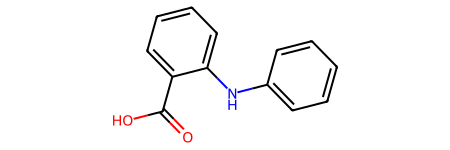

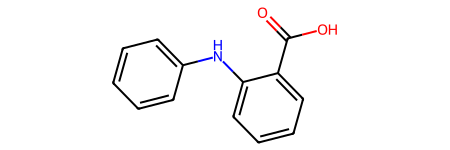

In [6]:
with open('../data/all_smiles.json', 'r') as f:
    smiles_in = json.load(f)
print(len(smiles_in))
with open('../data/all_smiles_standardized_mces/all_smiles_standardized.json', 'r') as f:
    smiles_out = json.load(f)
len(smiles_out)

std_smiles_map = {}
for k, v in smiles_in.items():
    for i, s in enumerate(v):
        std_smiles_map[s] = smiles_out[k][i]
len(std_smiles_map)
s = list(std_smiles_map.keys())[13112]
display(Chem.MolFromSmiles(s))
display(Chem.MolFromSmiles(std_smiles_map[s]))

In [7]:
spectra = list(load_from_mgf('../data/MassSpecGymSpectra.mgf'))
print(len(spectra))
spectra[0].metadata

413153


{'smiles': 'CCC\\C=C\\C=C\\C(CCC(=O)OC)C(CO)C(O)=O',
 'inchi': 'InChI=1S/C15H24O5/c1-3-4-5-6-7-8-12(9-10-14(17)20-2)13(11-16)15(18)19/h5-8,12-13,16H,3-4,9-11H2,1-2H3,(H,18,19)/b6-5+,8-7+',
 'inchikey': 'PVHUKALHRBPQNM-BSWSSELBSA-N',
 'precursor_mz': 285.169,
 'adduct': '[M+H]+',
 'parent_mass': '284.161724',
 'formula': 'C15H24O5',
 'precursor_formula': 'C15H25O5',
 'instrument_type': 'LC-ESI-QTOF',
 'identifier': 'MassSpecGymID0000001'}

### Standardize collision energies

In [8]:
# Code from Adamo: https://github.com/pluskal-lab/MassSpecGym/blob/8c6514cbbc2804ff57b5e9e39fe010a9d2ca310b/notebooks/simulation_preproc.ipynb.

def parse_ce_str(ce_str):

    ce_str = str(ce_str)
    normal_regex = re.compile(r'\d+(\.\d+)?')
    # ramped_regex = re.compile(r'\d+(\.\d+)?-\d+(\.\d+)?')
    ramped_regex = re.compile(r'\d+(\.\d+)?(V)?(-|->)\d+(\.\d+)?(V)?')
    ce_str = ce_str.split(";")[-1]
    try:
        if "%" in ce_str:
            normalized = True
        else:
            normalized = False
        if "-" in ce_str or "Ramp" in ce_str or "RAMP" in ce_str or "->" in ce_str:
            ramped = True
            ramped_ce = ramped_regex.search(ce_str).group(0)
            if "->" in ramped_ce:
                min_ce, max_ce = ramped_ce.split("->")
            else:
                min_ce, max_ce = ramped_ce.split("-")
            ce = 0.5*float(min_ce.strip("V")) + 0.5*float(max_ce.strip("V"))
        else:
            ramped = False
            ce = normal_regex.search(ce_str).group(0)
            ce = float(ce)
    except:
        ce = np.nan
        normalized = False
        ramped = False
    return ce, normalized, ramped

def convert_nce(row):
    # assumes charge factor of 1
    if row["normalized"]:
        nce = row["ce"]
        ace = (nce * row["precursor_mz"] * 1.) / 500.
    else:
        ace = row["ce"]
    return ace

In [21]:
ce_df = pd.DataFrame({
    "ce": [s.get('collision_energy') for s in tqdm(spectra)],
    "precursor_mz": [s.get('precursor_mz') for s in tqdm(spectra)]
})
print(ce_df['ce'].isna().sum())
ce_df["ce"], ce_df["normalized"], ce_df["ramped"] = zip(*ce_df["ce"].apply(parse_ce_str))
ce_df["ce"] = ce_df.apply(convert_nce, axis=1)
print(ce_df['ce'].isna().sum())
ce_df["ce_str"] = ce_df.apply(
    lambda row: f'{row["ce"]} (normalized={row["normalized"]}, ramped={row["ramped"]})'
                if not pd.isnull(row["ce"])
                else row["ce"],
    axis=1
)
ce_df

100%|██████████| 413153/413153 [00:04<00:00, 94396.00it/s]


271459
271853


,ce,precursor_mz,normalized,ramped,ce_str
0,NaN,285.169000,False,False,NaN
1,NaN,285.169000,False,False,NaN
2,NaN,285.170000,False,False,NaN
3,65.0,307.151581,False,False,"65.0 (normalized=False, ramped=False)"
4,45.0,307.151581,False,False,"45.0 (normalized=False, ramped=False)"
...,...,...,...,...,...
413148,55.0,420.166100,False,False,"55.0 (normalized=False, ramped=False)"
413149,40.0,420.166100,False,False,"40.0 (normalized=False, ramped=False)"
413150,30.0,420.166100,False,False,"30.0 (normalized=False, ramped=False)"
413151,20.0,420.166100,False,False,"20.0 (normalized=False, ramped=False)"


### Standardize instruments

In [35]:
def standardize_instrument_type(instr):
    if instr.startswith("LC-"):
        instr = instr[3:]
    if instr.startswith("ESI-"):
        instr = instr[4:]
    return instr

### Apply all the processing steps

In [37]:
spectra_new = []
for i, spec in enumerate(tqdm(spectra)):
    spec_new = spec.clone()
    spec_new.set('smiles', std_smiles_map[spec.get('smiles')])
    if 'collision_energy' in spec.metadata.keys():
        spec_new.set('collision_energy', ce_df['ce_str'].iloc[i])
    if 'instrument_type' in spec.metadata.keys():
        spec_new.set('instrument_type', standardize_instrument_type(spec.get('instrument_type')))
    spectra_new.append(spec_new)
print(len(spectra_new))
spectra_new[3].metadata

100%|██████████| 413153/413153 [01:17<00:00, 5339.25it/s]

413153


{'smiles': 'CCC/C=C/C=C/C(CCC(=O)OC)C(CO)C(=O)O',
 'inchi': 'InChI=1S/C15H24O5/c1-3-4-5-6-7-8-12(9-10-14(17)20-2)13(11-16)15(18)19/h5-8,12-13,16H,3-4,9-11H2,1-2H3,(H,18,19)/b6-5+,8-7+',
 'inchikey': 'PVHUKALHRBPQNM-BSWSSELBSA-N',
 'precursor_mz': 307.1515808105469,
 'adduct': '[M+Na]+',
 'parent_mass': '284.1623628105469',
 'formula': 'C15H24O5',
 'precursor_formula': 'C15H24NaO5',
 'instrument_type': 'QFT',
 'collision_energy': '65.0 (normalized=False, ramped=False)',
 'identifier': 'MassSpecGymID0000004'}

### Drop empty spectra

In [38]:
print(len(spectra_new))
spectra_new = [s for s in tqdm(spectra_new) if len(s.peaks) > 0]
print(len(spectra_new))

413153


100%|██████████| 413153/413153 [00:01<00:00, 239976.57it/s]

412402


### Convert to `.tsv`

In [39]:
df = []
for s in tqdm(spectra_new):
    row = {
        'mzs': ','.join([str(m) for m in s.peaks.mz]),
        'intensities': ','.join([str(m) for m in s.peaks.intensities])
    }
    row.update(s.metadata)
    df.append(row)
df = pd.DataFrame(df)
df

100%|██████████| 412402/412402 [00:21<00:00, 19309.09it/s]


,mzs,intensities,smiles,inchi,inchikey,precursor_mz,adduct,parent_mass,formula,precursor_formula,instrument_type,identifier,collision_energy
0,"79.054138,81.07048,82.074127,91.051361,93.0693...","0.38100102145045966,0.3953013278855976,0.10929...",CCC/C=C/C=C/C(CCC(=O)OC)C(CO)C(=O)O,InChI=1S/C15H24O5/c1-3-4-5-6-7-8-12(9-10-14(17...,PVHUKALHRBPQNM-BSWSSELBSA-N,285.169000,[M+H]+,284.161724,C15H24O5,C15H25O5,QTOF,MassSpecGymID0000001,NaN
1,"71.056847,79.052544,80.058685,81.0382,81.06829...","0.06227883934890304,0.39419674451521586,0.0651...",CCC/C=C/C=C/C(CCC(=O)OC)C(CO)C(=O)O,InChI=1S/C15H24O5/c1-3-4-5-6-7-8-12(9-10-14(17...,PVHUKALHRBPQNM-BSWSSELBSA-N,285.169000,[M+H]+,284.161724,C15H24O5,C15H25O5,QTOF,MassSpecGymID0000002,NaN
2,"79.052597,83.050301,91.057404,217.120804","0.7272727272727273,0.8484848484848485,1.0,0.63...",CCC/C=C/C=C/C(CCC(=O)OC)C(CO)C(=O)O,InChI=1S/C15H24O5/c1-3-4-5-6-7-8-12(9-10-14(17...,PVHUKALHRBPQNM-BSWSSELBSA-N,285.170000,[M+H]+,284.162724,C15H24O5,C15H25O5,QTOF,MassSpecGymID0000003,NaN
3,"50.149521,50.251616,50.872388,51.607089,52.201...","0.01164719,0.01650368,0.01631492,0.01584310000...",CCC/C=C/C=C/C(CCC(=O)OC)C(CO)C(=O)O,InChI=1S/C15H24O5/c1-3-4-5-6-7-8-12(9-10-14(17...,PVHUKALHRBPQNM-BSWSSELBSA-N,307.151581,[M+Na]+,284.1623628105469,C15H24O5,C15H24NaO5,QFT,MassSpecGymID0000004,"65.0 (normalized=False, ramped=False)"
4,"50.028968,50.261588,50.86206,51.129337,51.1694...","0.023949630000000003,0.017280439999999998,0.01...",CCC/C=C/C=C/C(CCC(=O)OC)C(CO)C(=O)O,InChI=1S/C15H24O5/c1-3-4-5-6-7-8-12(9-10-14(17...,PVHUKALHRBPQNM-BSWSSELBSA-N,307.151581,[M+Na]+,284.1623628105469,C15H24O5,C15H24NaO5,QFT,MassSpecGymID0000005,"45.0 (normalized=False, ramped=False)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
412397,"106.04,107.0478,108.0556,162.0298,206.0713,207...","0.03542691,0.03522694,0.05052716,0.04053966,0....",CC(C)(C=C)[C@]12C=C(C(=O)N\3[C@@]1(NC(=O)/C3=C...,"InChI=1S/C22H21N5O4/c1-4-20(2,3)21-10-17(28)19...",YEVSOYBNHBOQJZ-GCTRCSCRSA-N,420.166100,[M+H]+,419.158824,C22H21N5O4,C22H22N5O4,ITFT,MassSpecGymID0413149,"55.0 (normalized=False, ramped=False)"
412398,"233.0822,234.0662,234.09,235.074,261.0771,262....","0.03712262,0.04683089,0.23339173,0.04925900000...",CC(C)(C=C)[C@]12C=C(C(=O)N\3[C@@]1(NC(=O)/C3=C...,"InChI=1S/C22H21N5O4/c1-4-20(2,3)21-10-17(28)19...",YEVSOYBNHBOQJZ-GCTRCSCRSA-N,420.166100,[M+H]+,419.158824,C22H21N5O4,C22H22N5O4,ITFT,MassSpecGymID0413150,"40.0 (normalized=False, ramped=False)"
412399,"234.09,261.0771,262.0849,263.0927,289.072,290....","0.08706889999999999,0.35219439999999996,0.0831...",CC(C)(C=C)[C@]12C=C(C(=O)N\3[C@@]1(NC(=O)/C3=C...,"InChI=1S/C22H21N5O4/c1-4-20(2,3)21-10-17(28)19...",YEVSOYBNHBOQJZ-GCTRCSCRSA-N,420.166100,[M+H]+,419.158824,C22H21N5O4,C22H22N5O4,ITFT,MassSpecGymID0413151,"30.0 (normalized=False, ramped=False)"
412400,"261.0771,289.072,306.0985,317.0669,334.0934,33...","0.04071511,1.0,0.05180584,0.038061199999999996...",CC(C)(C=C)[C@]12C=C(C(=O)N\3[C@@]1(NC(=O)/C3=C...,"InChI=1S/C22H21N5O4/c1-4-20(2,3)21-10-17(28)19...",YEVSOYBNHBOQJZ-GCTRCSCRSA-N,420.166100,[M+H]+,419.158824,C22H21N5O4,C22H22N5O4,ITFT,MassSpecGymID0413152,"20.0 (normalized=False, ramped=False)"


### Double-check the validity of the SMILES standardization in the final `.tsv`

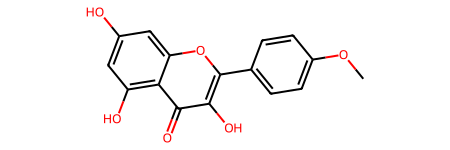

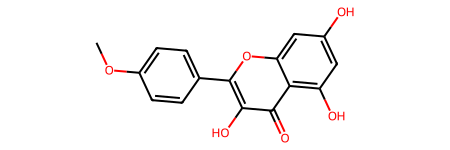

In [43]:
df_ = df.sample(1)
display(Chem.MolFromInchi(df_['inchi'].values[0]))
display(Chem.MolFromSmiles(df_['smiles'].values[0]))

In [44]:
df.to_csv('../data/data/MassSpecGym.tsv', index=False, sep='\t')

In [45]:
save_as_mgf(spectra_new, '../data/data/auxiliary/MassSpecGym.mgf')